In [17]:
%matplotlib inline

import os, pickle, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.color_palette('winter')
sns.set()

In [11]:
%%time
# Load Data
data_dir = '../data'

with open(os.path.join(data_dir, 'prep_train.pkl'), 'rb') as f:
    train = pickle.load(f)
    
with open(os.path.join(data_dir, 'validation.pkl'), 'rb') as f:
    vals = pickle.load(f)
    
with open(os.path.join(data_dir, 'evaluation.pkl'), 'rb') as f:
    evals = pickle.load(f)

CPU times: user 36.3 s, sys: 58.7 s, total: 1min 34s
Wall time: 2min 5s


In [3]:
# データの一部だけ使う
_train = train.iloc[:100000]
_train.sort_values(by=['id', 'date'], ascending=True, inplace=True)
_train.shape

/Users/imamuramasataka/Documents/kaggle/m5-forecasting/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(100000, 20)

In [18]:
train.head()

,id,d,values,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price,Type
0,HOBBIES_1_008_CA_1_validation,d_1,12,CA_1,HOBBIES_1_008,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,train
1,HOBBIES_1_008_CA_1_validation,d_2,15,CA_1,HOBBIES_1_008,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,train
2,HOBBIES_1_008_CA_1_validation,d_3,0,CA_1,HOBBIES_1_008,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,train
3,HOBBIES_1_008_CA_1_validation,d_4,0,CA_1,HOBBIES_1_008,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,1,0.459961,train
4,HOBBIES_1_008_CA_1_validation,d_5,0,CA_1,HOBBIES_1_008,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,1,0.459961,train


In [19]:
vals.head()

,id,d,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price,Type
0,HOBBIES_1_001_CA_1_validation,d_1914,CA_1,HOBBIES_1_001,2016-04-25,11613,Monday,3,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
1,HOBBIES_1_001_CA_1_validation,d_1915,CA_1,HOBBIES_1_001,2016-04-26,11613,Tuesday,4,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
2,HOBBIES_1_001_CA_1_validation,d_1916,CA_1,HOBBIES_1_001,2016-04-27,11613,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
3,HOBBIES_1_001_CA_1_validation,d_1917,CA_1,HOBBIES_1_001,2016-04-28,11613,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
4,HOBBIES_1_001_CA_1_validation,d_1918,CA_1,HOBBIES_1_001,2016-04-29,11613,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals


In [20]:
evals.head()

,id,d,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price,Type
0,HOBBIES_1_001_CA_1_evaluation,d_1942,CA_1,HOBBIES_1_001,2016-05-23,11617,Monday,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
1,HOBBIES_1_001_CA_1_evaluation,d_1943,CA_1,HOBBIES_1_001,2016-05-24,11617,Tuesday,4,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
2,HOBBIES_1_001_CA_1_evaluation,d_1944,CA_1,HOBBIES_1_001,2016-05-25,11617,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
3,HOBBIES_1_001_CA_1_evaluation,d_1945,CA_1,HOBBIES_1_001,2016-05-26,11617,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals
4,HOBBIES_1_001_CA_1_evaluation,d_1946,CA_1,HOBBIES_1_001,2016-05-27,11617,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38,vals


In [21]:
def preprocessing(train, vals, evals):
    
    train['Type'] = 'train'
    vals['Type'] = 'vals'
    evals['Type'] = 'evals'
    df = pd.concat([train, vals, evals], axis=0, ignore_index=True)
    del train, vals, evals
    gc.collect()
    
    df['date'] = pd.to_datetime(df['date'].values)
    
    # Sort
    df.sort_values(by=['id', 'date'], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # X days past sell price  ########################################################
    
    for i in np.arange(1, 8, 1):
        col_name = f'sell_price_past_{i}'
        _past_day = pd.date_range(start=df['date'].min(), freq='D', periods=i)
        df[col_name] = df['sell_price'].shift(i)
        df.loc[df['date'].isin(_past_day), col_name] = np.nan    
    
    # Item Category  ########################################################
    df['item_type'] = df['item_id'].apply(lambda x: x.split('_')[0])
    
    # LabelEncoder  ########################################################
    cols = ['store_id', 'item_id', 'weekday', 'item_type']
    for c in cols:
        lbl = LabelEncoder()
        df[c] = lbl.fit_transform(df[c].values)
        
    # Set Category  ########################################################
    add_cols = ['month', 'year', 'snap']
    cols.extend(add_cols)
    for c in cols:
        df[c] = df[c].astype('category')
    
    # delete columns  ########################################################
    del_col = ['wm_yr_wk',
               'event_name_1', 'event_type_1', 
               'event_name_2', 'event_type_2', 
               'snap_CA', 'snap_TX', 'snap_WI',
              ]
    df.drop(del_col, axis=1, inplace=True)
    
    # Divide Train, vals
    train = df[df['Type'] == 'train']
    vals = df[df['Type'] == 'vals']
    evals = df[df['Type'] == 'evals']
    del df
    gc.collect()
    
    return train, vals, evals

In [22]:
%%time
train, vals, evals = preprocessing(train, vals, evals)


KeyboardInterrupt



In [25]:
train.isnull().sum()

id                     0
d                      0
values                 0
store_id               0
item_id                0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    42341567
event_type_1    42341567
event_name_2    45933474
event_type_2    45933474
snap_CA                0
snap_TX                0
snap_WI                0
snap                   0
sell_price             0
Type                   0
dtype: int64

In [7]:
# def preprocessing(train, vals, evals):
    
#     train['date'] = pd.to_datetime(train['date'].values)
#     vals['date'] = pd.to_datetime(vals['date'].values)
#     evals['date'] = pd.to_datetime(evals['date'].values)
    
#     # Sort
#     train.sort_values(by=['id', 'date'], ascending=True, inplace=True)
#     train.reset_index(drop=True, inplace=True)
#     vals.sort_values(by=['id', 'date'], ascending=True, inplace=True)
#     vals.reset_index(drop=True, inplace=True)
#     evals.sort_values(by=['id', 'date'], ascending=True, inplace=True)
#     evals.reset_index(drop=True, inplace=True)
    
#     # Prep Date  ########################################################
#     _max_year = evals['year'].max()
#     train['year_diff'] = _max_year - train['year']
#     vals['year_diff'] = _max_year - train['year']
#     evals['year_diff'] = _max_year - train['year']
    
#     # X days past sell price  ########################################################
    
#     def XPastDaySellPrice(train, vals, evals, past_day=1):
#         col_name = f'sell_price_past_{past_day}'
#         _past_day = pd.date_range(start=train['date'].min(), freq='D', periods=past_day)
#         train[col_name] = train['sell_price'].shift(past_day)
#         train.loc[train['date'].isin(_past_day), col_name] = np.nan

#         _past_day = pd.date_range(start=vals['date'].min(), freq='D', periods=past_day)
#         print(_past_day)
#         vals[col_name] = vals['sell_price'].shift(past_day)
#         vals.loc[vals['date'].isin(_past_day), col_name] = np.nan
#         # 前の値で埋めておく
#         vals[col_name].fillna(method='bfill')

#         _past_day = pd.date_range(start=evals['date'].min(), freq='D', periods=past_day)
#         print(_past_day)
#         evals[col_name] = evals['sell_price'].shift(past_day)
#         evals.loc[evals['date'].isin(_past_day), col_name] = np.nan
#         # 前の値で埋めておく
#         evals[col_name].fillna(method='bfill')
        
#         return train, vals, evals
        
#     train, vals, evals = XPastDaySellPrice(train, vals, evals, past_day=1)
#     train, vals, evals = XPastDaySellPrice(train, vals, evals, past_day=3)
#     train, vals, evals = XPastDaySellPrice(train, vals, evals, past_day=7)
    
#     # Item Category  ########################################################
#     train['item_type'] = train['item_id'].apply(lambda x: x.split('_')[0])
#     vals['item_type'] = vals['item_id'].apply(lambda x: x.split('_')[0])
#     evals['item_type'] = evals['item_id'].apply(lambda x: x.split('_')[0])
    
#     # LabelEncoder  ########################################################
# #     cols = ['store_id', 'item_id', 'weekday', 'item_type']
# #     for c in cols:
# #         lbl = LabelEncoder()
# #         train[c] = lbl.fit_transform(train[c].values)
# #         vals[c] = lbl.transform(vals[c].values)
# #         evals[c] = lbl.transform(evals[c].values)
        
#     # Set Category  ########################################################
# #     add_cols = ['month', 'year', 'snap']
# #     cols.extend(add_cols)
# #     for c in cols:
# #         train[c] = train[c].astype('category')
# #         vals[c] = vals[c].astype('category')
# #         evals[c] = evals[c].astype('category')
        
#     # Sort by Date  ########################################################
# #     train.sort_values(by='date', ascending=True, inplace=True)
# #     train.reset_index(drop=True, inplace=True)
# #     del train['date'], vals['date'], evals['date']
    
#     # delete columns  ########################################################
# #     del_col = ['wm_yr_wk',
# #                'event_name_1', 'event_type_1', 
# #                'event_name_2', 'event_type_2', 
# #                'snap_CA', 'snap_TX', 'snap_WI'
# #               ]
# #     train.drop(del_col, axis=1, inplace=True)
# #     vals.drop(del_col, axis=1, inplace=True)
# #     evals.drop(del_col, axis=1, inplace=True)
    
#     return train, vals, evals

In [23]:
# %%time
# _train, vals, evals = preprocessing(_train, vals, evals)

In [9]:
_train.head()

,id,d,values,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price,year_diff,sell_price_past_1,sell_price_past_3,sell_price_past_7,item_type
0,FOODS_1_001_CA_1_validation,d_1,3,CA_1,FOODS_1_001,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,2.0,5,NaN,NaN,NaN,FOODS
1,FOODS_1_001_CA_1_validation,d_2,0,CA_1,FOODS_1_001,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,2.0,5,2.0,NaN,NaN,FOODS
2,FOODS_1_001_CA_1_validation,d_3,0,CA_1,FOODS_1_001,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,2.0,5,2.0,NaN,NaN,FOODS
3,FOODS_1_001_CA_1_validation,d_4,1,CA_1,FOODS_1_001,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,1,2.0,5,2.0,2.0,NaN,FOODS
4,FOODS_1_001_CA_1_validation,d_5,4,CA_1,FOODS_1_001,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,1,2.0,5,2.0,2.0,NaN,FOODS


In [9]:
vals.head()

,id,d,store_id,item_id,weekday,wday,month,year,snap,sell_price,year_diff,item_type
0,HOBBIES_1_001_CA_1_validation,d_1914,0,1437,1,3,4,2016,0,8.38,5,1
1,HOBBIES_1_001_CA_1_validation,d_1915,0,1437,5,4,4,2016,0,8.38,5,1
2,HOBBIES_1_001_CA_1_validation,d_1916,0,1437,6,5,4,2016,0,8.38,5,1
3,HOBBIES_1_001_CA_1_validation,d_1917,0,1437,4,6,4,2016,0,8.38,5,1
4,HOBBIES_1_001_CA_1_validation,d_1918,0,1437,0,7,4,2016,0,8.38,5,1


In [10]:
evals.head()

,id,d,store_id,item_id,weekday,wday,month,year,snap,sell_price,year_diff,item_type
0,HOBBIES_1_001_CA_1_evaluation,d_1942,0,1437,1,3,5,2016,0,8.38,5,1
1,HOBBIES_1_001_CA_1_evaluation,d_1943,0,1437,5,4,5,2016,0,8.38,5,1
2,HOBBIES_1_001_CA_1_evaluation,d_1944,0,1437,6,5,5,2016,0,8.38,5,1
3,HOBBIES_1_001_CA_1_evaluation,d_1945,0,1437,4,6,5,2016,0,8.38,5,1
4,HOBBIES_1_001_CA_1_evaluation,d_1946,0,1437,0,7,5,2016,0,8.38,5,1


In [11]:
train.dtypes

id              object
d               object
values           int16
store_id      category
item_id       category
weekday       category
wday              int8
month         category
year          category
snap          category
sell_price     float16
year_diff        int16
item_type     category
dtype: object

In [12]:
vals.dtypes

id              object
d               object
store_id      category
item_id       category
weekday       category
wday             int64
month         category
year          category
snap          category
sell_price     float64
year_diff        int16
item_type     category
dtype: object

In [13]:
evals.dtypes

id              object
d               object
store_id      category
item_id       category
weekday       category
wday             int64
month         category
year          category
snap          category
sell_price     float64
year_diff        int16
item_type     category
dtype: object

In [14]:
class LGBMModel:
    
    def __init__(self, train, validation, evaluation, test_size=0.1):
        self.train_id = train['id'].values
        self.target = train['values'].values
        self.val_id = validation['id'].values
        self.eval_id = evaluation['id'].values
        self.val_d = validation['d'].values
        self.eval_d = evaluation['d'].values

        X = train.drop(['id', 'd', 'values'], axis=1)
        self.features = X.columns
        self.X = X.values
        self.vals = validation[self.features].values
        self.evals = evaluation[self.features].values

        self.importances = np.zeros((len(self.features)))
        self.importance_df = None
        self.best_score = 10000
        self.models = []

    def train(self, params, cv, num_boost_round=1000, early_stopping_rounds=20, verbose=200):
        print('LightGBM Model Training...')
        for i, (trn_idx, val_idx) in enumerate(cv.split(self.X)):

            train_data = lgb.Dataset(self.X[trn_idx], label=self.target[trn_idx])
            valid_data = lgb.Dataset(self.X[val_idx], label=self.target[val_idx], reference=train_data)

            model = lgb.train(params,
                              train_data,
                              valid_sets=[train_data, valid_data],
                              valid_names=['train', 'eval'],
                              num_boost_round=num_boost_round,
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=verbose
                              )
            self.models.append(model)

            self.importances += model.feature_importance() / cv.get_n_splits()

            pred = model.predict(self.X[val_idx], num_iteration=model.best_iteration)
            rmse = np.sqrt(mean_squared_error(y_true=self.target[val_idx], y_pred=pred))
            print(f'{i} Fold  RMSE: {rmse:.3f}')
            print('#'*30)

        self.importance_df = pd.DataFrame({
            'features': self.features,
            'importance': self.importances
        })

        return self.models, self.importance_df
    
    
    def evaluate(self):
        assert len(self.models) != 0, 'Model is not trained...'
        print('Evaluate...')
        
        pred_val = np.zeros(len(self.val_id))
        pred_eval = np.zeros(len(self.eval_id))
        
        for model in self.models:
            pred_val += model.predict(self.vals, num_iteration=model.best_iteration) / len(self.models)
            pred_eval += model.predict(self.evals, num_iteration=model.best_iteration) / len(self.models)
            
        res_val = pd.DataFrame({
            'id': self.val_id,
            'date': self.val_d,
            'pred': pred_val
        })
        
        res_eval = pd.DataFrame({
            'id': self.eval_id,
            'date': self.eval_d,
            'pred': pred_eval
        })
        
        # For submit
        print('Creating Submission')
        res = pd.DataFrame()
        F_list = [f'F{i}' for i in range(1, 29, 1)]
        # Validation
        id_list = res_val['id'].unique()
        for _id in tqdm(id_list):
            temp = res_val[res_val['id'] == _id].sort_values(by='date').reset_index(drop=True)
            temp = temp[['pred']].T.reset_index(drop=True)
            temp.columns = F_list
            temp['id'] = _id
            c = ['id'] + F_list
            temp = temp[c]
            res = pd.concat([res, temp], axis=0, ignore_index=True)
            
        # Evaluation
        id_list = res_eval['id'].unique()
        for _id in tqdm(id_list):
            temp = res_eval[res_eval['id'] == _id].sort_values(by='date').reset_index(drop=True)
            temp = temp[['pred']].T.reset_index(drop=True)
            temp.columns = F_list
            temp['id'] = _id
            c = ['id'] + F_list
            temp = temp[c]
            res = pd.concat([res, temp], axis=0, ignore_index=True)
            
        print('FINISH')
        
        return res
    
    def visualize_feature_importance(self):
        _importance_df = self.importance_df.sort_values(by='importance', ascending=False)
        fig = plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='features', data=_importance_df)
        plt.title('Feature Imporrance')
        plt.show()

In [15]:
%%time
# config
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
}

cv = KFold(n_splits=3)
num_boost_round = 5000
early_stopping_rounds = 200
verbose = 1000

lgbm = LGBMModel(train, vals, evals)
model, importance_df = lgbm.train(params, cv, num_boost_round, early_stopping_rounds, verbose)

LightGBM Model Training...
Training until validation scores don't improve for 200 rounds
[1000]	train's rmse: 2.83913	eval's rmse: 4.1485
[2000]	train's rmse: 2.73187	eval's rmse: 4.12117
Early stopping, best iteration is:
[2707]	train's rmse: 2.69309	eval's rmse: 4.11399
0 Fold  RMSE: 4.114
##############################
Training until validation scores don't improve for 200 rounds
[1000]	train's rmse: 3.08412	eval's rmse: 3.33188
[2000]	train's rmse: 2.96426	eval's rmse: 3.27096
[3000]	train's rmse: 2.88977	eval's rmse: 3.24033
[4000]	train's rmse: 2.83538	eval's rmse: 3.21728
[5000]	train's rmse: 2.80299	eval's rmse: 3.20723
Did not meet early stopping. Best iteration is:
[5000]	train's rmse: 2.80299	eval's rmse: 3.20723
1 Fold  RMSE: 3.207
##############################
Training until validation scores don't improve for 200 rounds
[1000]	train's rmse: 3.33579	eval's rmse: 2.86239
[2000]	train's rmse: 3.21161	eval's rmse: 2.82237
[3000]	train's rmse: 3.14314	eval's rmse: 2.80517
[40

NameError: name 'tqdm' is not defined

In [18]:
# %%time
# res = lgbm.evaluate()

Evaluate...
Creating Submission


/Users/imamuramasataka/Documents/kaggle/m5-forecasting/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:83: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/imamuramasataka/Documents/kaggle/m5-forecasting/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



FINISH
CPU times: user 1h 25min 45s, sys: 1min, total: 1h 26min 46s
Wall time: 1h 4min 24s


In [19]:
res.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.472225,0.383934,0.369026,0.375098,0.509660,0.697997,0.714322,0.523369,0.442678,0.422780,0.430939,0.555306,0.689721,0.714322,0.523369,0.442678,0.363986,0.371270,0.505831,0.663010,0.686612,0.468396,0.380105,0.363986,0.371270,0.505831,0.663010,0.686612
1,HOBBIES_1_002_CA_1_validation,0.657542,0.560203,0.544178,0.551767,0.695375,0.948075,0.968188,0.708233,0.624591,0.603575,0.613251,0.740569,0.945749,0.968188,0.708233,0.624591,0.539138,0.547938,0.691547,0.913088,0.934529,0.653713,0.556374,0.539138,0.547938,0.691547,0.913088,0.934529
2,HOBBIES_1_003_CA_1_validation,0.765791,0.648113,0.636026,0.648264,0.812212,1.120937,1.128612,0.807070,0.703088,0.689422,0.700335,0.847993,1.106328,1.128612,0.807070,0.703088,0.625622,0.635660,0.799608,1.073667,1.094953,0.753188,0.635509,0.625622,0.635660,0.799608,1.073667,1.094953
3,HOBBIES_1_004_CA_1_validation,1.810311,1.712972,1.696547,1.704136,1.847745,2.150119,2.170232,1.861002,1.777360,1.755945,1.765620,1.892939,2.147793,2.170232,1.861002,1.777360,1.691507,1.700308,1.843916,2.115132,2.136573,1.806482,1.709143,1.691507,1.700308,1.843916,2.115132,2.136573
4,HOBBIES_1_005_CA_1_validation,0.747937,0.647919,0.636428,0.649467,0.795755,1.065687,1.061732,0.771399,0.685078,0.672809,0.683722,0.813720,1.034295,1.061732,0.771399,0.685078,0.626024,0.636062,0.782350,1.018650,1.045088,0.734532,0.634514,0.626024,0.636062,0.782350,1.018650,1.045088


In [20]:
res.shape

(60980, 29)

In [21]:
res.to_csv('../data/output/submission.csv', index=False)

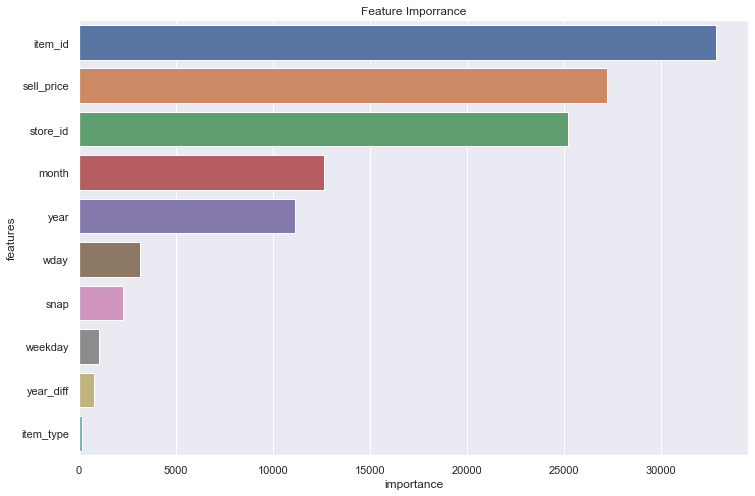

In [23]:
lgbm.visualize_feature_importance()